# Augmenting Data from Other Data Sources

In this notebook, we will use Augmentor to process images that are stored in memory, and are not read locally from a directory on a hard disk.

To demonstrate this, we will use Keras to access the MNIST dataset, which is part of the `keras.datasets` module.

Note: you can view a tutorial on using Augmentor with your own images, here <https://github.com/mdbloice/Augmentor/blob/master/notebooks/Augmentor_Keras.ipynb> 

First we make a number of imports:

In [1]:
import Augmentor

import keras
from keras.models import Sequential
from keras.layers import Dense, Dropout, Flatten
from keras.layers import Conv2D, MaxPooling2D
from keras.datasets import mnist

import numpy as np

import matplotlib.pyplot as plt
%matplotlib inline

Using TensorFlow backend.


## Get MNIST Data

To get the MNIST digit data, we can just called `load_data()` from the `datasets` module. Keras comes with a number of pre-arranged data sets for testing and experimentation.

In [2]:
(x_train, y_train), (x_test, y_test) = mnist.load_data()

Because we are going to feed the network categorical data, we should convert `y_train` and `y_test`:

In [3]:
y_train = Augmentor.Pipeline.categorical_labels(y_train)
y_test = Augmentor.Pipeline.categorical_labels(y_test)

### MNIST Data Format

Let's examine the type and shape of the MNIST data:

In [4]:
num_images, width, height = np.shape(x_train)
print("The matrix x_train contains %s images, with dimenions of %s x %s." % (num_images, width, height))

The matrix x_train contains 60000 images, with dimenions of 28 x 28.


If we take a look at one row of the matrix, let's say at index 0, you will see it contains a single image of shape (28, 28):

In [5]:
np.shape(x_train[0])

(28, 28)

We can use matplotlib's `imshow` function to render this array as an image:

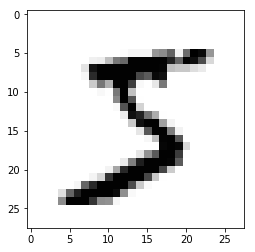

In [6]:
plt.imshow(x_train[0], cmap="Greys");

Later, we will pass this entire matrix, containing 60,000 images, to an Augmentor function, which will generate batches of augmented images from this original data.

## Create a Pipeline

It is perfectly fine to create a pipeline object without needing to point to a directory on your hard drive. Do this if you want to perform an augmentation task on data from another location, such as from the web or another framework such as Keras.

In [7]:
p = Augmentor.Pipeline()

If you then check the pipeline `p`'s status, you will see it has no images or classes associated with it:

In [8]:
p.status()

Operations: 0
Images: 0
Classes: 0

You can remove operations using the appropriate index and the remove_operation(index) function.


Adding operations is done as normal: 

In [9]:
p.rotate(probability=1, max_left_rotation=5, max_right_rotation=5)
p.status()

Operations: 1
	0: RotateRange (max_right_rotation=5.0 max_left_rotation=-5.0 probability=1 )
Images: 0
Classes: 0

You can remove operations using the appropriate index and the remove_operation(index) function.


## Design a Neural Network

We will use a simple convolutional neural network using Keras to train a model using the augmented MNIST data:

In [10]:
num_classes = 10
input_shape = (28, 28, 1)

model = Sequential()
model.add(Conv2D(32, kernel_size=(3, 3),
                 activation='relu',
                 input_shape=input_shape))
model.add(Conv2D(64, (3, 3), activation='relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.25))
model.add(Flatten())
model.add(Dense(128, activation='relu'))
model.add(Dropout(0.5))
model.add(Dense(num_classes, activation='softmax'))

Once a network has been defined, you can compile it so that the model is ready to be trained with data:

In [11]:
model.compile(loss=keras.losses.categorical_crossentropy,
              optimizer=keras.optimizers.Adadelta(),
              metrics=['accuracy'])

Now that the network is ready, we can create a generator using Augmentor, and pass this generator to the neural network created above.

## Create a Generator

Now, you can use the MNIST data you gathered earlier and use this to create an generator. The generator will augment the data that you pass to it indefinitely and this can be fed into a neural network in order to train it. In this case we will use the images stored in the matrix `x_train` and their corresponding labels stored in the `y_train` array.

We will use the generator later, so we will stored in a variable `g`:

In [12]:
batch_size = 128
g = p.keras_generator_from_array(x_train, y_train, batch_size=10)

We can take a look at what the generator outputs (the generator returns a batch of images and a batch of corresponding labels as a tuple):

In [13]:
X, y = next(g)

Let's take a look at the ouput of one image, again using index 0 from the batch of images returned by the generator:

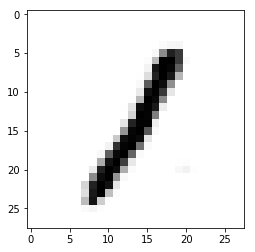

In [14]:
plt.imshow(X[0].reshape(28,28), cmap="Greys")

It's label should also correspond to the image shown above, which we can access using `y`:

In [15]:
print("The image above has the label %s." % int(np.nonzero(y[0])[0]))

The image above has the label 1.


## Fit the Model using the Generator

Now we can fit the model using our generator:

In [16]:
h = model.fit_generator(g, steps_per_epoch=len(x_train)/batch_size, epochs=10, verbose=1)

Epoch 1/10
468/468 [==============================] - 6s 12ms/step - loss: 0.7717 - acc: 0.7530
Epoch 2/10
468/468 [==============================] - 4s 9ms/step - loss: 0.3109 - acc: 0.9090
Epoch 3/10
468/468 [==============================] - 4s 9ms/step - loss: 0.2563 - acc: 0.9235
Epoch 4/10
468/468 [==============================] - 4s 9ms/step - loss: 0.2093 - acc: 0.9327
Epoch 5/10
468/468 [==============================] - 4s 9ms/step - loss: 0.1895 - acc: 0.9462
Epoch 6/10
468/468 [==============================] - 4s 9ms/step - loss: 0.1667 - acc: 0.9498
Epoch 7/10
468/468 [==============================] - 4s 9ms/step - loss: 0.1385 - acc: 0.9566
Epoch 8/10
468/468 [==============================] - 4s 9ms/step - loss: 0.1374 - acc: 0.9577
Epoch 9/10
468/468 [==============================] - 4s 9ms/step - loss: 0.1219 - acc: 0.9600
Epoch 10/10
468/468 [==============================] - 4s 9ms/step - loss: 0.1232 - acc: 0.9615


## Summary
You can use data loaded into memory rather than reading from disk using Augmentor's `keras_generator_from_array` function. This has the advantage that the online augmentation is much faster than when reading from disk.